In [ ]:
# The '-d' parameter shows the destination for where the files should go
!unzip "drive/MyDrive/Datathon/datathonindoml-2022.zip" -d "drive/MyDrive/Datathon/"

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/Datathon/train/train/6309.tif  
  inflating: drive/MyDrive/Datathon/train/train/631.tif  
  inflating: drive/MyDrive/Datathon/train/train/6310.tif  
  inflating: drive/MyDrive/Datathon/train/train/6311.tif  
  inflating: drive/MyDrive/Datathon/train/train/6312.tif  
  inflating: drive/MyDrive/Datathon/train/train/6313.tif  
  inflating: drive/MyDrive/Datathon/train/train/6314.tif  
  inflating: drive/MyDrive/Datathon/train/train/6315.tif  
  inflating: drive/MyDrive/Datathon/train/train/6316.tif  
  inflating: drive/MyDrive/Datathon/train/train/6317.tif  
  inflating: drive/MyDrive/Datathon/train/train/6318.tif  
  inflating: drive/MyDrive/Datathon/train/train/6319.tif  
  inflating: drive/MyDrive/Datathon/train/train/632.tif  
  inflating: drive/MyDrive/Datathon/train/train/6320.tif  
  inflating: drive/MyDrive/Datathon/train/train/6321.tif  
  inflating: drive/MyDrive/Datathon/train/train/6322.tif  
  infla

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
from keras.layers import Input
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.8.2
Hub version: 0.12.0
GPU not available


# Accessing the Data

In [ ]:
# The labels of our data

train_labels_csv = pd.read_csv("drive/MyDrive/Datathon/train_labels.csv")

print(train_labels_csv.describe())
print(train_labels_csv.head())

                 id         label
count  16000.000000  16000.000000
mean    7999.500000      7.512437
std     4618.946489      4.601214
min        0.000000      0.000000
25%     3999.750000      4.000000
50%     7999.500000      8.000000
75%    11999.250000     12.000000
max    15999.000000     15.000000
   id  label
0   0      1
1   1     13
2   2     13
3   3     14
4   4      6


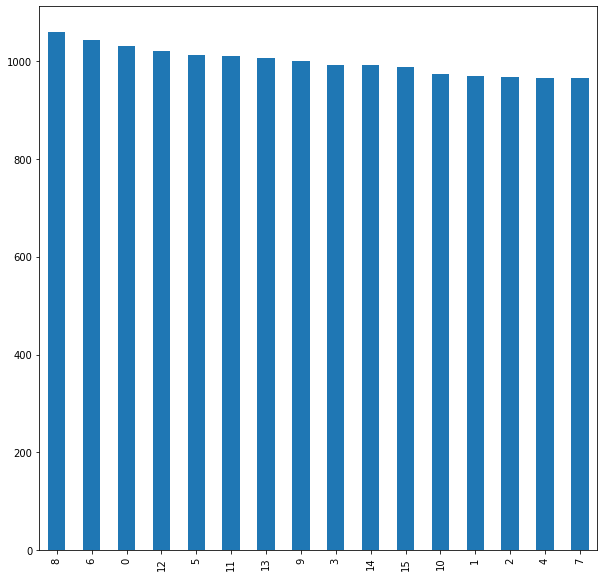

In [ ]:
# How many images are there of each document?
train_labels_csv["label"].value_counts().plot.bar(figsize=(10, 10));

Creating list of file paths to images

In [ ]:
# Create pathnames from image ID's
train_path = "drive/MyDrive/Datathon/train/train/"
filenames = [train_path + str(fname) + ".tif" for fname in train_labels_csv["id"]]      # Fetching training files' IDs from train_labels_csv

val_path = "drive/MyDrive/Datathon/validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]       # Fetching Validation files' IDs from the validation set

# Check the first 10 filenames
filenames[:5], val_filenames[:5]

(['drive/MyDrive/Datathon/train/train/0.tif',
  'drive/MyDrive/Datathon/train/train/1.tif',
  'drive/MyDrive/Datathon/train/train/2.tif',
  'drive/MyDrive/Datathon/train/train/3.tif',
  'drive/MyDrive/Datathon/train/train/4.tif'],
 ['drive/MyDrive/Datathon/validation/validation/17801.tif',
  'drive/MyDrive/Datathon/validation/validation/17802.tif',
  'drive/MyDrive/Datathon/validation/validation/17803.tif',
  'drive/MyDrive/Datathon/validation/validation/17804.tif',
  'drive/MyDrive/Datathon/validation/validation/17805.tif'])

In [ ]:
len(filenames), len(val_filenames)

(16000, 900)

In [ ]:
len(os.listdir(train_path))

16000

In [ ]:
os.listdir(train_path)[0]


'0.tif'

In [ ]:
# Check whether number of filenames matches number of actual image files

if len(os.listdir(train_path)) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files


In [ ]:
# Check whether number of val_filenames matches number of actual image files in the Validation set

if len(os.listdir(val_path)) == len(val_filenames):
  print("val_filenames match actual amount of files in Validation set")
else:
  print("val_filenames do not match actual amount of files in Validation set, check the target directory.")

val_filenames match actual amount of files in Validation set


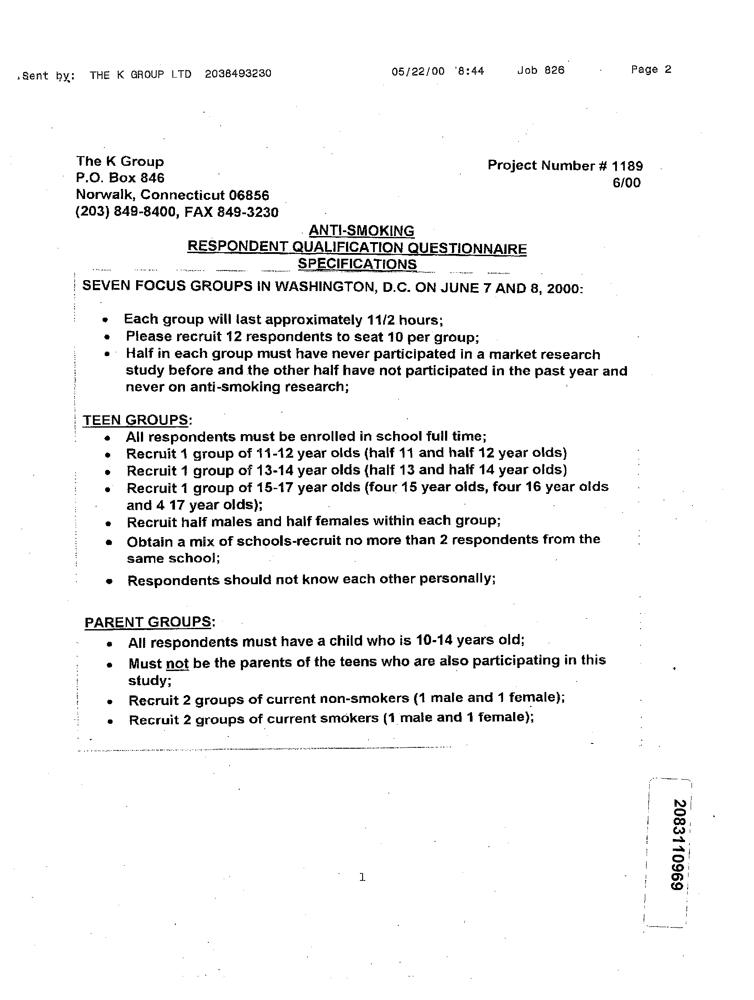

In [ ]:
# # Check an image directly from a filepath
Image.open(filenames[1])

In [ ]:
labels = train_labels_csv["label"].to_numpy() # convert labels column to NumPy array (from Training Dataset)
labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")    

In [ ]:
# Finding the unique labels
unique_labels = np.unique(labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
labels[0] == unique_labels

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_labels) for label in labels]
boolean_labels[:2]

[array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False])]

In [ ]:
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Preprocessing Images (Turning Images into Tensors)

Until now, the labels have been in a numberical format but the filepaths are not. The data needs to be in numerical form as we are using TensorFlow

 *NOTE* Run this Cell again if a Google Drive Timeout occurs for the first time

In [ ]:
# Convert image to NumPy array

image = imread(filenames[0]) # read in an image
image.shape

(1000, 786)

In [ ]:
import tensorflow as tf
tf.constant(image)

<tf.Tensor: shape=(1000, 786), dtype=uint8, numpy=
array([[255, 255, 255, ..., 255, 255, 255],
       [116,  90, 254, ..., 255, 255, 255],
       [ 73,  38, 254, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)>

## Renaming the files from tif to jpeg

*NOTE*: Running the next cell may take a significant amount of time

In [ ]:
# Renaming the training filenames from (.tif) to (.jpg) in order to convert them into tensors later on
import os
for i in range(len(filenames)):
  os.rename(filenames[i], filenames[i].split(".")[0] + '.jpeg') 

*NOTE*: Running the next cell may take a significant amount of time

In [ ]:
# Renaming the validation filenames from (.tif) to (.jpg) in order to convert them into tensors later on
import os
for i in range(len(val_filenames)):
  os.rename(val_filenames[i], val_filenames[i].split(".")[0] + '.jpeg')     #rename the files (.tif) into (.jpeg)

## Converting all images into RGB Format

*NOTE*:  Running the next cell may take a significant amount of time

In [ ]:
# Create pathnames from image ID's
train_path = "drive/MyDrive/Datathon/train/train/"
filenames = [train_path + str(fname) for fname in os.listdir(train_path)]     # Fetching training files' IDs from train_labels_csv

# Converting all images into RGB Format in order to turn it into tensors

for infile in filenames:
    outfile = infile
    im = Image.open(infile)
    out = im.convert("RGB")
    out.save(outfile, "JPEG", quality=90)

*NOTE*:  Running the next cell may take a significant amount of time

In [ ]:
val_path = "drive/MyDrive/Datathon/validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]

# Converting all images into RGB Format in order to turn it into tensors
for infile in val_filenames:
    outfile = infile
    im = Image.open(infile)
    out = im.convert("RGB")
    out.save(outfile, "JPEG", quality=90)

## Setting up variables

In [ ]:
train_directory = '/drive/MyDrive/Datathon/train/train/'
val_directory = '/drive/MyDrive/Datathon/validation/validation/'

td =pd.read_csv("drive/MyDrive/Datathon/train_labels.csv") # Update the path



## Select subset for training and validation data
num_train_samples = 1600
num_val_samples = 100

train_ids = td['id'].to_list()[:num_train_samples]
train_labels = td['label'].to_list()[:num_train_samples]
train_images = []
for id in train_ids:
    train_images.append(os.path.join(train_directory,"%s.tif"%id))

In [ ]:

# Set number of images to use for experimenting
NUM_IMAGES = 4000 

curr_class = 0
## Preparing the Dataset
dict_of_img_labels = {'img':[], 'label':[]}

max_sample_per_class = NUM_IMAGES/16
arr = np.zeros(16)
train_ids = []

for i in range(len(td["id"])):
    id = td["id"][i]
    label = td["label"][i]

    count = arr[label]

    if count >= max_sample_per_class:
      continue

    train_ids.append(id)
    arr[label]+=1

In [ ]:
# Create pathnames from image ID's
train_path = "drive/MyDrive/Datathon/train/train/"
filenames = [train_path + str(id) + ".jpeg" for id in train_ids]                          # Fetching training files' IDs from train_ids we made earlier for 4000 images

val_path = "drive/MyDrive/Datathon/validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]       # Fetching Validation files' IDs from the validation set

# Check the first 10 filenames
filenames[:5] , val_filenames[:5]

(['drive/MyDrive/Datathon/train/train/0.jpeg',
  'drive/MyDrive/Datathon/train/train/1.jpeg',
  'drive/MyDrive/Datathon/train/train/2.jpeg',
  'drive/MyDrive/Datathon/train/train/3.jpeg',
  'drive/MyDrive/Datathon/train/train/4.jpeg'],
 ['drive/MyDrive/Datathon/validation/validation/17801.jpeg',
  'drive/MyDrive/Datathon/validation/validation/17802.jpeg',
  'drive/MyDrive/Datathon/validation/validation/17803.jpeg',
  'drive/MyDrive/Datathon/validation/validation/17804.jpeg',
  'drive/MyDrive/Datathon/validation/validation/17805.jpeg'])

In [ ]:
# Setup X & y variables again as the filenames and val_filenames have been modified
X = filenames
y = boolean_labels

U = val_filenames
v = boolean_labels

In [ ]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split



# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

# The validation set here is used for Evaluating the model since we got labels in the training set
len(X_train), len(y_train), len(X_val), len(y_val)

(3200, 3200, 800, 800)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/MyDrive/Datathon/train/train/4247.jpeg',
  'drive/MyDrive/Datathon/train/train/423.jpeg',
  'drive/MyDrive/Datathon/train/train/2991.jpeg',
  'drive/MyDrive/Datathon/train/train/1221.jpeg',
  'drive/MyDrive/Datathon/train/train/506.jpeg'],
 [array([False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False]),
  array([False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False])])

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [ ]:
# demofile = "drive/MyDrive/Datathon/validation/validation/17801.jpeg"
demofile = "drive/MyDrive/Datathon/train/train/0.jpeg"
image = tf.io.read_file(demofile)
image = tf.image.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32)
# Resize the image to our desired size (224, 244)
image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.41814008, 0.41814008, 0.41814008],
        [0.98974156, 0.98974156, 0.98974156],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.5057433 , 0.5057433 , 0.5057433 ],
        [0.9972164 , 0.9972164 , 0.9972164 ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.  

In [ ]:
process_image(val_filenames[2])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)>

# Creating Data Batches

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.bool, name=None)))

# Creating and Training a Model

## Building a Model

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# we will build the model using the Keras API

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer). Softmax will predict the probabilities for each class for each image
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # An optimizer helping our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 16)                16032     
                                                                 
Total params: 5,448,745
Trainable params: 16,032
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

We Will be using 2 callbacks namely, TensorBoard and Early Stopping

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Datathon/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

## Training a Model (On a Subset of the Training data)

In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 60

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

*NOTE* : Running the cell below may take significant amount of time

In [ ]:
# Fit the model to the data
model = train_model()

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/60
100/100 [==============================] - 41s 293ms/step - loss: 2.2088 - accuracy: 0.3331 - val_loss: 1.8055 - val_accuracy: 0.4588
Epoch 2/60
100/100 [==============================] - 31s 306ms/step - loss: 1.7615 - accuracy: 0.4872 - val_loss: 1.7113 - val_accuracy: 0.4800
Epoch 3/60
100/100 [==============================] - 29s 293ms/step - loss: 1.6431 - accuracy: 0.5269 - val_loss: 1.6746 - val_accuracy: 0.4963
Epoch 4/60
100/100 [==============================] - 33s 335ms/step - loss: 1.5651 - accuracy: 0.5475 - val_loss: 1.6561 - val_accuracy: 0.5175
Epoch 5/60
100/100 [==============================] - 33s 334ms/step - loss: 1.5063 - accuracy: 0.5719 - val_loss: 1.6464 - val_accuracy: 0.5263
Epoch 6/60
100/100 [==============================] - 34s 339ms/step - loss: 1.4588 - accuracy: 0.5863 - val_loss: 1.6419 - val_accuracy: 0.5300
Epoch 7/60
100/100 [=============

In [ ]:
%tensorboard --logdir drive/MyDrive/Datathon/logs     # Checking the tensorBoard logs

<IPython.core.display.Javascript object>

## Making Predictions

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

25/25 [==============================] - 22s 249ms/step


array([[1.14403211e-01, 6.49840757e-02, 8.91470059e-04, ...,
        5.97931370e-02, 1.26936566e-02, 5.93959503e-02],
       [1.27232879e-01, 2.71297172e-02, 1.79902047e-01, ...,
        3.57430167e-02, 1.57554835e-01, 1.01328187e-01],
       [6.30517304e-02, 2.37116907e-02, 1.18327186e-01, ...,
        1.69581193e-02, 6.48489594e-02, 3.66052926e-01],
       ...,
       [1.79326944e-02, 1.40720472e-01, 1.84526516e-03, ...,
        1.36457598e-02, 1.27302408e-02, 8.87154788e-03],
       [5.25470939e-04, 2.11980548e-02, 1.26632702e-04, ...,
        4.54504669e-01, 4.52412479e-02, 6.81605414e-02],
       [1.39051676e-02, 2.65940875e-02, 6.44671917e-01, ...,
        2.95962393e-03, 1.25794141e-02, 6.16390072e-02]], dtype=float32)

In [ ]:
# Check the shape of predictions
predictions.shape

(800, 16)

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_labels[np.argmax(predictions[0])]}") # the predicted label# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_labels[np.argmax(predictions[0])]}") # the predicted label

[1.1440321e-01 6.4984076e-02 8.9147006e-04 4.9254421e-02 8.2318415e-04
 7.6424014e-03 5.8962789e-04 4.1663113e-01 5.2029174e-04 9.2536662e-05
 1.3239304e-02 1.9863544e-01 4.1014660e-04 5.9793137e-02 1.2693657e-02
 5.9395950e-02]
Max value (probability of prediction): 0.41663113236427307
Sum: 1.0
Max index: 7
Predicted label: 7
[1.1440321e-01 6.4984076e-02 8.9147006e-04 4.9254421e-02 8.2318415e-04
 7.6424014e-03 5.8962789e-04 4.1663113e-01 5.2029174e-04 9.2536662e-05
 1.3239304e-02 1.9863544e-01 4.1014660e-04 5.9793137e-02 1.2693657e-02
 5.9395950e-02]
Max value (probability of prediction): 0.41663113236427307
Sum: 1.0
Max index: 7
Predicted label: 7


In [ ]:
# Turn prediction probabilities into their labels (Document Types)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

11

# Save the Model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Datathon/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Load the Model

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 4000 images from the Training Dataset
save_model(model, suffix="initial-4000-images-Adam")

Saving model to: drive/MyDrive/Datathon/models/20221007-04581665118720-initial-4000-images-Adam.h5...


'drive/MyDrive/Datathon/models/20221007-04581665118720-initial-4000-images-Adam.h5'

In [ ]:
# Load our model trained on 1000 images
loaded_model = load_model('drive/MyDrive/Datathon/models/20221007-04581665118720-initial-4000-images-Adam.h5')

Loading saved model from: drive/MyDrive/Datathon/models/20221007-04581665118720-initial-4000-images-Adam.h5


Comparing the saved and loaded models by evaluating them in val_data

In [ ]:
# Evaluate the previous model
model.evaluate(val_data)

25/25 [==============================] - 6s 235ms/step - loss: 1.6641 - accuracy: 0.5450


[1.6640989780426025, 0.5450000166893005]

In [ ]:
# Evaluate the loaded model
loaded_model.evaluate(val_data)

25/25 [==============================] - 6s 233ms/step - loss: 1.6641 - accuracy: 0.5450


[1.6640989780426025, 0.5450000166893005]

# Training the Model on Full Data

In [ ]:
# Create pathnames from image ID's
train_path = "drive/MyDrive/Datathon/train/train/"
filenames = [train_path + str(fname) + ".jpeg" for fname in train_labels_csv["id"]]      # Fetching training files' IDs from train_labels_csv

val_path = "drive/MyDrive/Datathon/validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]       # Fetching Validation files' IDs from the validation set

In [ ]:
len(filenames)

16000

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

# The size of the full dataset
len(X), len(y)

(16000, 16000)

In [ ]:
X[:5], y[:5]

(['drive/MyDrive/Datathon/train/train/0.jpeg',
  'drive/MyDrive/Datathon/train/train/1.jpeg',
  'drive/MyDrive/Datathon/train/train/2.jpeg',
  'drive/MyDrive/Datathon/train/train/3.jpeg',
  'drive/MyDrive/Datathon/train/train/4.jpeg'],
 [array([False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False]),
  array([False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False])])

In [ ]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.bool, name=None))>

In [ ]:
# Instantiate a new model for training on the full dataset
full_model = create_model()
full_model.summary()

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 16)                16032     
                                                                 
Total params: 5,448,745
Trainable params: 16,032
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, so we monitor only training accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=2)

In [ ]:
%tensorboard --logdir drive/MyDrive/Datathon/logs

<IPython.core.display.Javascript object>

*NOTE* : Running the cell below will take a significant amount of time

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/60
500/500 [==============================] - 118s 228ms/step - loss: 1.6195 - accuracy: 0.5037
Epoch 2/60
500/500 [==============================] - 115s 229ms/step - loss: 1.3535 - accuracy: 0.5842
Epoch 3/60
500/500 [==============================] - 117s 233ms/step - loss: 1.2793 - accuracy: 0.6064
Epoch 4/60
500/500 [==============================] - 112s 224ms/step - loss: 1.2330 - accuracy: 0.6187
Epoch 5/60
500/500 [==============================] - 112s 225ms/step - loss: 1.1994 - accuracy: 0.6306
Epoch 6/60
500/500 [==============================] - 114s 229ms/step - loss: 1.1729 - accuracy: 0.6403
Epoch 7/60
500/500 [==============================] - 126s 252ms/step - loss: 1.1510 - accuracy: 0.6461
Epoch 8/60
500/500 [==============================] - 116s 231ms/step - loss: 1.1324 - accuracy: 0.6516
Epoch 9/60
500/500 [==============================] - 117s 233ms/step - loss: 1.1162 - accuracy: 0.6568
Epoch 10/60
500/500 [==============================] - 117s 233m

In [ ]:
save_model(full_model, suffix="full-trained-adam") # saving the full model

Saving model to: drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5...


'drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5'

In [ ]:
# Load our model trained on full Dataset
loaded_full_model = load_model('drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5')

Loading saved model from: drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5


In [ ]:
loaded_full_model

# Making Predictions on the Validation Dataset

In [ ]:
import os
# Load validation image filenames
val_path = "drive/MyDrive/Datathon/validation/validation/"
val_filenames = [val_path + fname for fname in os.listdir(val_path)]

val_filenames[:10]

['drive/MyDrive/Datathon/validation/validation/17801.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17802.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17803.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17804.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17805.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17806.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17807.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17808.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17809.jpeg',
 'drive/MyDrive/Datathon/validation/validation/17810.jpeg']

In [ ]:
# How many validation images are there?
len(val_filenames)

900

In [ ]:
# Create validation data batch so as to turn it into tensors and then fit it in our model
val_data = create_data_batches(val_filenames, test_data=True)     # here we pass the argument "test_data" because we dont have any labels for the validation dataset

Creating test data batches...


In [ ]:
# Make predictions on the validation data batch using the loaded full model
val_predictions = loaded_full_model.predict(val_data, verbose=1)

29/29 [==============================] - 105s 4s/step


In [ ]:
# Check out the validation predictions
val_predictions[:2]

array([[5.1437399e-07, 4.3972582e-03, 2.1789685e-11, 2.4280457e-04,
        2.3531145e-01, 9.0493023e-02, 5.3642626e-04, 8.3245588e-03,
        8.1409685e-02, 5.1512122e-02, 1.4033027e-03, 5.2189612e-01,
        4.1266466e-03, 3.1893040e-05, 3.1414774e-04, 4.5239794e-09],
       [7.0191886e-06, 4.9563689e-05, 1.7180669e-06, 1.3196905e-08,
        1.2712053e-08, 1.2472419e-03, 9.9341691e-01, 1.8954447e-07,
        7.5933448e-10, 4.4249403e-03, 8.1670959e-07, 6.8819481e-06,
        4.2633319e-04, 9.1523162e-07, 4.1673513e-04, 7.6549560e-07]],
      dtype=float32)

# Preparing the sample predictions to submit on Kaggle

In [ ]:
# Getting the list of validation set IDs
val_id = [id for id in os.listdir(val_path)]
val_ids = []
for item in val_id:
  val_ids.append(int(item.split(".")[0]))
len(val_ids)

900

## Getting the list of Validation set Predictions

In [ ]:
# Load the Trained Model
# loaded_full_model = load_model('drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5')

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = loaded_full_model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

29/29 [==============================] - 40s 1s/step


array([[5.14373994e-07, 4.39725816e-03, 2.17896846e-11, ...,
        3.18930397e-05, 3.14147735e-04, 4.52397941e-09],
       [7.01918862e-06, 4.95636887e-05, 1.71806687e-06, ...,
        9.15231624e-07, 4.16735129e-04, 7.65495599e-07],
       [1.22774269e-09, 6.78319134e-09, 7.32282751e-14, ...,
        2.35429468e-07, 1.42730798e-07, 2.16775053e-11],
       ...,
       [1.00183137e-01, 4.69281251e-04, 4.50700327e-06, ...,
        2.46717185e-02, 7.27823412e-04, 7.11862028e-01],
       [1.83145147e-07, 5.83819144e-07, 7.34706118e-05, ...,
        1.12065318e-04, 1.44733838e-06, 1.43635925e-05],
       [5.17190900e-04, 2.07140204e-03, 1.71505015e-08, ...,
        1.16151590e-02, 2.99977660e-06, 2.26214851e-08]], dtype=float32)

In [ ]:
# Check the shape of predictions
predictions.shape

(900, 16)

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_labels[np.argmax(predictions[0])]}") # the predicted label

[5.1437399e-07 4.3972582e-03 2.1789685e-11 2.4280457e-04 2.3531145e-01
 9.0493023e-02 5.3642626e-04 8.3245588e-03 8.1409685e-02 5.1512122e-02
 1.4033027e-03 5.2189612e-01 4.1266466e-03 3.1893040e-05 3.1414774e-04
 4.5239794e-09]
Max value (probability of prediction): 0.5218961238861084
Sum: 1.0
Max index: 11
Predicted label: 11


In [ ]:
# Getting the predicted labels in array val_pred_labels[]
val_pred_labels = []
for i in range(len(val_ids)):
  val_pred_labels.append(get_pred_label(predictions[i]))
val_pred_labels[:5]

[11, 6, 4, 8, 3]

In [ ]:
len(val_ids), len(val_pred_labels)

(900, 900)

In [ ]:
# Fitting the data into Pandas dataframe
data = []
for i in range(len(val_ids)):
  data.append((val_ids[i], val_pred_labels[i]))
data[:5]

[(17801, 11), (17802, 6), (17803, 4), (17804, 8), (17805, 3)]

In [ ]:
df = pd.DataFrame(data, columns=['id','label'])
df.head()

,id,label
0,17801,11
1,17802,6
2,17803,4
3,17804,8
4,17805,3


In [ ]:
# Saving the predicted labels on validation set images in CSV
df.to_csv(r'drive/MyDrive/Datathon/kaggle-indoml-submission.csv', index=False)

In [ ]:
# Function to test the validation data stored in 'data_path' with the model stored in 'model_path'
# here, model_path = "drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5" 
#       data_path = "drive/MyDrive/Datathon/validation/validation"

def test(model_path, data_path):
  # Load the fully trained model
  loaded_full_model = load_model(model_path)

  # Load validation image filenames
  val_path = data_path
  val_filenames = [val_path + fname for fname in os.listdir(val_path)]

  # Getting the list of validation set IDs
  val_id = [id for id in os.listdir(val_path)]
  val_ids = []
  for item in val_id:
    val_ids.append(int(item.split(".")[0]))
  
  # Create validation data batch so as to turn it into tensors and then fit it in our model
  val_data = create_data_batches(val_filenames, test_data=True) 

  # Make predictions on the validation data 
  predictions = loaded_full_model.predict(val_data, verbose=1) 
  
  # Getting the predicted labels in array val_pred_labels[]
  val_pred_labels = []
  for i in range(len(val_ids)):
    val_pred_labels.append(get_pred_label(predictions[i]))
  
  # Fitting the data into Pandas dataframe
  data = []
  for i in range(len(val_ids)):
    data.append((val_ids[i], val_pred_labels[i]))
  df = pd.DataFrame(data, columns=['id','label'])

  # Saving the predicted labels on validation set images in CSV
  # Saving the predictions to predicted_label.csv file and saving it inside the datathon folder in GDrive
  # df.to_csv(r'drive/MyDrive/Datathon/predicted_label2.csv', index=False) 
df.to_csv(r'drive/MyDrive/Datathon/predicted_label.csv', index=False)  

In [ ]:
model_path = "drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5" # Path where the fully trained model is stored
data_path = "drive/MyDrive/Datathon/validation/validation/"           # Path where the validation sample images are present
test(model_path, data_path)